In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

sigmas=pd.read_csv('sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv('returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv('volumes.csv.gz',index_col=0,parse_dates=[0])

a = pd.DataFrame(data=2.5*1e-4, index=volumes.index, columns=volumes.columns)
b = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns) # fix volatility model
s = pd.DataFrame(data=1*1e-4, index=volumes.index, columns=volumes.columns)

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

np.random.seed(0)
noise=pd.DataFrame(index=returns.index, columns=returns.columns, 
                   data=0.1*np.random.randn(*returns.values.shape))
return_estimate= returns + noise
return_estimate.USDOLLAR = returns.USDOLLAR
alpha_model = cp.AlphaSource(return_estimate)

simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

from cvx_portfolio.data import series_factor_model_covariance
exposures_pan, factor_sigma_pan, idyos_df = series_factor_model_covariance(returns, variance_explained=.75,
                                                                           freq='MS',lookback_periods = 12)
risk_model = cp.FactorModelSigma(exposures_pan, factor_sigma_pan, idyos_df)

results={}

## Simulations

In [39]:
policies={}
gamma_risks=[ 30., 60, 100., 110., 300., 600., 1000., 1100.]
gamma_tcosts= [30., 100., 300., 1000.]
for gamma_risk in gamma_risks:
    for gamma_tcost in gamma_tcosts : 
        policies[(gamma_risk, gamma_tcost)] = \
                cp.SinglePeriodOpt(alpha_model, [gamma_risk*risk_model, gamma_tcost*simulated_tcost],
                                                #simulated_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

ERROR:root:The solver None failed. Defaulting to no trades


In [40]:
result_df=pd.DataFrame()
for k in all_results:
    result_df.loc[k[0], k[1]] = all_results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'gamma_tcost'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

In [51]:
used_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)]
benchmark_returns = pd.Series(index=used_returns.index, data=used_returns.USDOLLAR)

result_df_used= result_df#[[100.,300.,1000.]]

table=pd.DataFrame()
table[r'Excess return']=\
result_df_used.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Excess risk']= \
    result_df_used.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
table[r'Transaction costs']=\
    result_df_used.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()    

table_print=pd.DataFrame(table,copy=True)
table_print=table_print.set_index(table_print.index.set_levels([["%g"%i for i in table_print.index.levels[0]],
                      ["%g"%i for i in table_print.index.levels[1]]]))
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{lllll}
\toprule
    &     & Excess return & Excess risk & Transaction costs \\
gamma_tcost & gamma_risk &               &             &                   \\
\midrule
100 & 30 &        28.24\% &      22.44\% &            69.48\% \\
    & 60 &        27.00\% &      21.20\% &            69.95\% \\
    & 100 &        26.24\% &      20.05\% &            70.32\% \\
    & 110 &        26.15\% &      19.81\% &            70.41\% \\
    & 300 &        26.87\% &      15.73\% &            70.06\% \\
    & 600 &        26.35\% &      12.20\% &            66.76\% \\
    & 1000 &        25.55\% &       9.91\% &            62.77\% \\
    & 1100 &        25.23\% &       9.50\% &            61.96\% \\
300 & 30 &        17.40\% &      17.01\% &             3.36\% \\
    & 60 &        17.26\% &      16.17\% &             3.31\% \\
    & 100 &        16.77\% &      15.88\% &             3.29\% \\
    & 110 &        16.64\% &      15.80\% &             3.29\% \\
    & 300 &        12.96\% &

### DOnt plot gamma trade = 30, get rid of turnover 

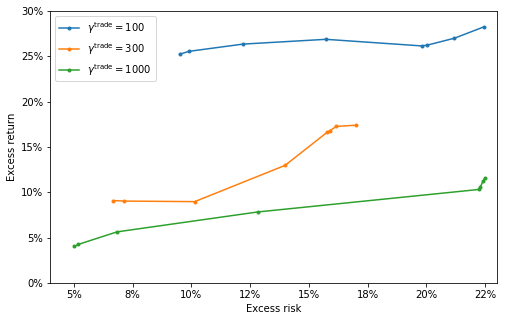

In [53]:
plt.figure(figsize=(8,5))
for gamma_tcost in table.index.levels[0][:]:
    x = table.loc[gamma_tcost]['Excess risk']
    y = table.loc[gamma_tcost]['Excess return']
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='upper left')
plt.xlabel('Excess risk')
plt.ylabel('Excess return')
plt.xlim([4,23])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier.png')

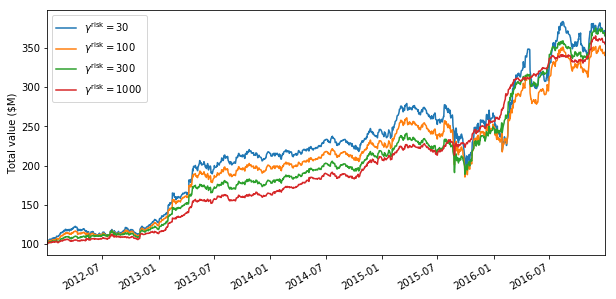

In [12]:
gamma_tcost=100#gamma_tcosts[2]
plt.figure(figsize=(10,5))

[(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^\mathrm{risk} = %g$'%i) for i in gamma_risks]
plt.legend(loc='upper left')# if i==0 else 'upper left')
plt.ylabel('Total value (\$M)')
plt.savefig(plotdir+'spo_valueintime.png')

In [15]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,30.0,100.0,300.0,1000.0
gamma_risk,,,,
30.0,0.279506,1.263188,1.026669,0.516143
100.0,0.153190,1.313718,1.059932,0.473930
300.0,-0.005531,1.715168,0.930027,0.611939
1000.0,-0.183357,2.589567,1.268232,0.819903


In [16]:
result_df.applymap(lambda x: x.policy_time.mean() + x.simulation_time.mean())

gamma_tcost,30.0,100.0,300.0,1000.0
gamma_risk,,,,
30.0,0.631352,0.824512,0.879987,0.671997
100.0,0.705715,0.806136,0.878431,0.772043
300.0,0.731359,0.724765,0.872514,0.772960
1000.0,0.761064,0.813199,0.874184,0.811322


In [17]:
result_df.applymap(lambda x: x.policy_time.sum() + x.simulation_time.sum())

gamma_tcost,30.0,100.0,300.0,1000.0
gamma_risk,,,,
30.0,794.240667,1037.236284,1107.023405,845.372384
100.0,887.789501,1014.118917,1105.065884,971.230425
300.0,920.049039,911.754739,1097.623225,972.383445
1000.0,957.418989,1023.004778,1099.724065,1020.643411


## Other diagnostics

([30.0, 100.0, 300.0, 1000.0], 1000.0)

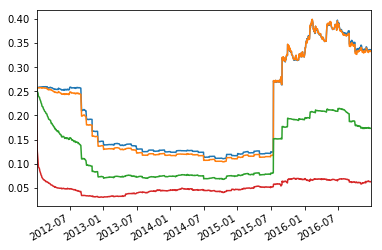

In [20]:
gamma_tcost=gamma_tcosts[-1]
[(np.sqrt(250)*np.sqrt(results[(i, gamma_tcost)].policy_FactorModelSigma)).plot() for i in gamma_risks]
gamma_risks, gamma_tcost

([30.0, 100.0, 300.0, 1000.0], 300.0)

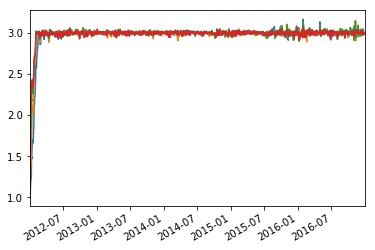

In [21]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([30.0, 100.0, 300.0, 1000.0], 100.0)

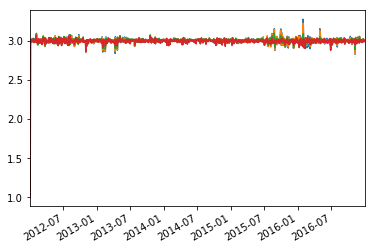

In [22]:
[results[(i, gamma_tcosts[1])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[1]

([30.0, 100.0, 300.0, 1000.0], 300.0)

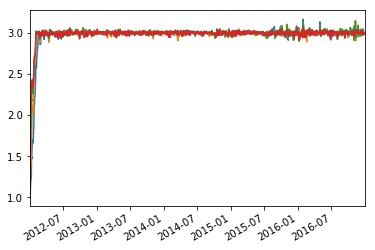

In [23]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([30.0, 100.0, 300.0, 1000.0], 300.0)

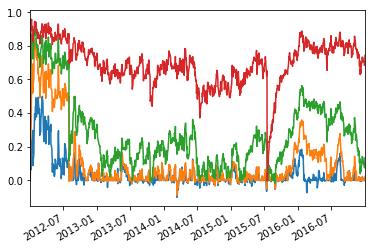

In [24]:
[results[(i, gamma_tcosts[2])].w.USDOLLAR.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([30.0, 100.0, 300.0, 1000.0], 300.0)

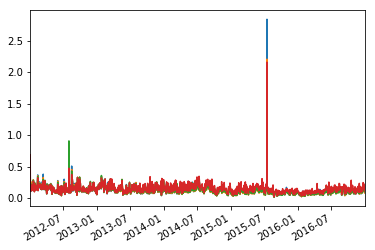

In [25]:
[results[(i, gamma_tcosts[2])].turnover.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [26]:
# res.turnover.plot()
# res.policy_TcostModel.sum(1).plot(secondary_y=True)

NameError: name 'res' is not defined

In [ ]:
# res.policy_TcostModel.sum(1).plot()
# res.simulator_TcostModel.sum(1).plot(secondary_y=True)

In [ ]:
# (res.policy_TcostModel.sum(1)).tail(100).plot(style='.-')
# (res.simulator_TcostModel.sum(1)/res.v).tail(100).plot(style='.-')